# Imports and setup

In [1]:
import sys, os

import s3fs
import xarray as xr

import progressbar

import warnings

from math import sqrt
from joblib import Parallel, delayed

import numpy as np

from matplotlib import pyplot as plt

sys.path.append('../utilities')
import GrIS_committedSLR_calibration_utilities

import boto3

import pickle


import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# Setup

In [2]:
start_year = 2007.
end_year = 2015.

grid_size = 50000.

grid_extent = np.array([-720500.0, 960500.0, -3450500.0, -569500.0])

dh_mod_obs_sigma_multiplier = 300.

debug_plots = True

## Compare dhdynAnom with dhdynAnom_new

In [15]:
ensembleID = 'A1091'

# Read dhdynAnom_old
s3 = s3fs.S3FileSystem(anon=False)
filename = s3.glob('dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom_old/*' + ensembleID + '*6079.nc.zarr')[0]
ds = xr.open_dataset('s3://' + filename, engine='zarr')
x_mod = ds['x'].data
y_mod = ds['y'].data
dh_dynanom_old = ds['dh_dynanom']
dh_dynanom_old_sum = np.sum(dh_dynanom_old, axis=0)
ds.close()

# Read dhdynAnom_new
s3 = s3fs.S3FileSystem(anon=False)
filename = s3.glob('dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom_new/*' + ensembleID + '*.nc.zarr')[0]
ds = xr.open_dataset('s3://' + filename, engine='zarr')
x_mod = ds['x'].data
y_mod = ds['y'].data
dh_dynanom_new = ds['dh_dynanom']
dh_dynanom_new_sum = np.sum(dh_dynanom_new, axis=0)
ds.close()

# Read dhdynAnom
s3 = s3fs.S3FileSystem(anon=False)
filename = s3.glob('dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom/*' + ensembleID + '*6079.nc.zarr')[0]
ds = xr.open_dataset('s3://' + filename, engine='zarr')
x_mod = ds['x'].data
y_mod = ds['y'].data
dh_dynanom = ds['dh_dynanom']
dh_dynanom_sum = np.sum(dh_dynanom, axis=0)
ds.close()

dh_dynanom_old_sum = dh_dynanom_old_sum.fillna(np.nan).where(dh_dynanom_old_sum < 1000.)
dh_dynanom_new_sum = dh_dynanom_new_sum.fillna(np.nan).where(dh_dynanom_new_sum < 1000.)
dh_dynanom_sum = dh_dynanom_sum.fillna(np.nan).where(dh_dynanom_sum < 1000.)


Text(0.5, 1.0, 'difference')

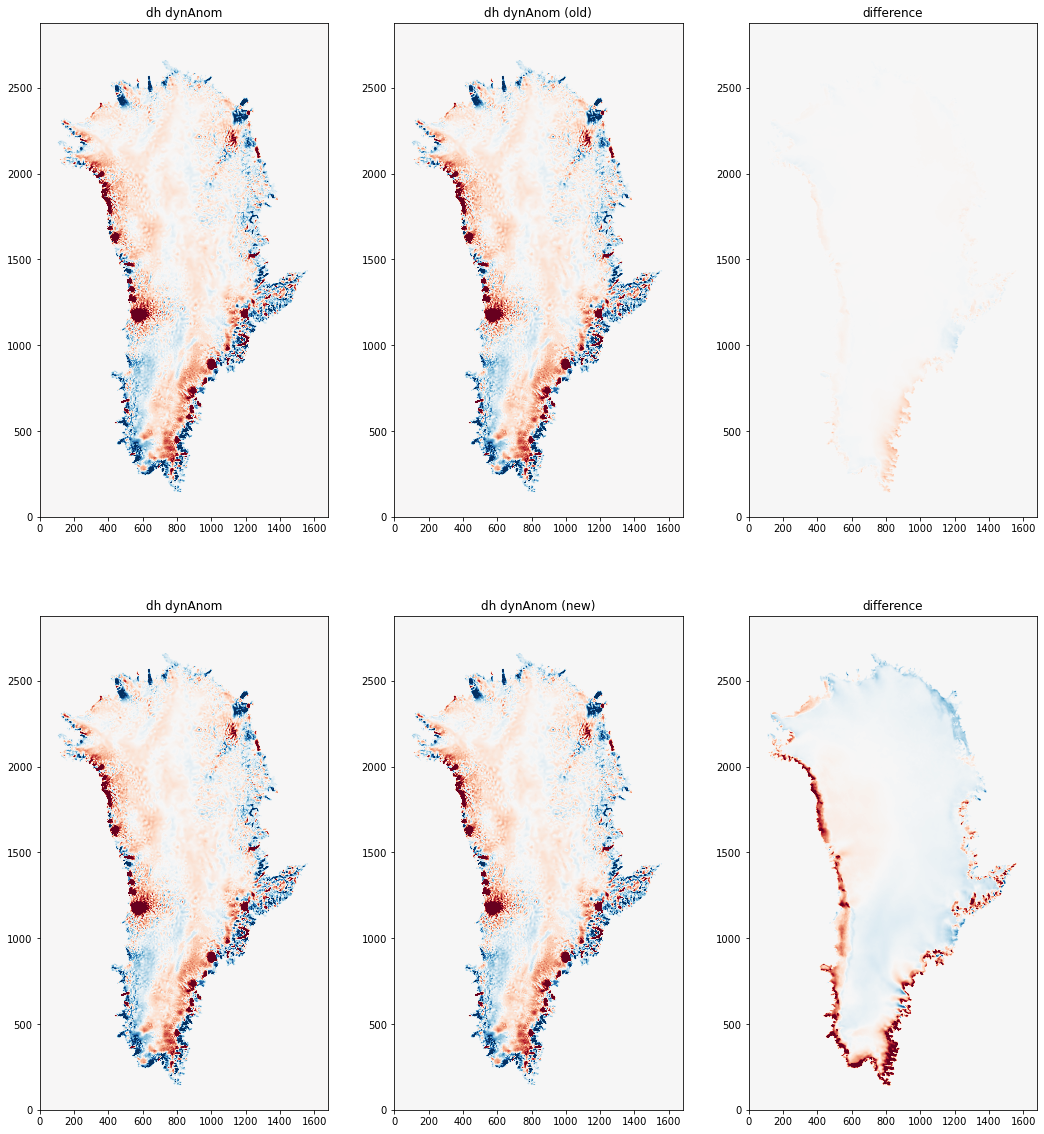

In [16]:
fig, ax = plt.subplots(2,3,figsize=(18,20))

ax[0,0].imshow(dh_dynanom_sum, vmin=-10, vmax=+10, cmap='RdBu', origin='lower')
ax[0,1].imshow(dh_dynanom_old_sum, vmin=-10, vmax=+10, cmap='RdBu', origin='lower')
ax[0,2].imshow(dh_dynanom_old_sum - dh_dynanom_sum, vmin=-1, vmax=+1, cmap='RdBu', origin='lower')

ax[0,0].set_title('dh dynAnom')
ax[0,1].set_title('dh dynAnom (old)')
ax[0,2].set_title('difference')

ax[1,0].imshow(dh_dynanom_sum, vmin=-10, vmax=+10, cmap='RdBu', origin='lower')
ax[1,1].imshow(dh_dynanom_new_sum, vmin=-10, vmax=+10, cmap='RdBu', origin='lower')
ax[1,2].imshow(dh_dynanom_new_sum - dh_dynanom_sum, vmin=-1, vmax=+1, cmap='RdBu', origin='lower')

ax[1,0].set_title('dh dynAnom')
ax[1,1].set_title('dh dynAnom (new)')
ax[1,2].set_title('difference')


# Plot SERAC obs and various model thickness quantities

In [ ]:
ensembleID = 'A0000'

# Read SERAC
dh_dyn_obs = GrIS_committedSLR_calibration_utilities.read_SERAC_obs('SERAC/SERACAnnualRates2021JanIGSPres.csv')
dh_dyn_obs_selected = GrIS_committedSLR_calibration_utilities.select_dh_obs(dh_dyn_obs, startYear=start_year, endYear=end_year) #, dhThresholdMax=-1)

# Read thickness

# Read smb_anom

# Read dhdynAnom
s3 = s3fs.S3FileSystem(anon=False)
filename = s3.glob('dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom_new/*' + ensembleID + '*.zarr')[0]
ds = xr.open_dataset('s3://' + filename, engine='zarr')
x_mod = ds['x'].data
y_mod = ds['y'].data
dh_dynanom = ds['dh_dynanom']
dh_dynanom_sum = np.sum(dh_dynanom_new, axis=0)
ds.close()

dh_dynanom_sum = dh_dynanom_sum.fillna(np.nan).where(dh_dynanom_sum < 1000.)

# Plot
fig, ax = plt.subplots(1,4,figsize=(18,8))

im_dh = ax[0].scatter([d['x']/1000 for d in dh_dyn_obs_selected], \
                      [d['y']/1000 for d in dh_dyn_obs_selected], \
                    c=[d['dh0715'] for d in dh_dyn_obs_selected], cmap='RdBu', vmin=-20, vmax=20)

im_dh = ax[3].imshow(dh_dynanom_sum, extent=[e/1000. for e in grid_extent], \
               cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
               aspect='auto')
    
ax[0].set_title('SERAC obs')
ax[1].set_title('mod thickness')
ax[2].set_title('smb anom')
ax[3].set_title('mod dhdynAnom')
